# 설계 및 공사


### 1. 전략가가 보는 데이터 만들기

- 타이어 상태 확인 ?
- 이번 코너에서 오버/언더스티어가 나면 어떤 영향이 있을까?

In [25]:
import logging


# 또는 더 강력하게 모든 fastf1 관련 로그를 끄려면:
logging.getLogger('fastf1').setLevel(logging.ERROR)

In [9]:
fastf1.plotting.setup_mpl(misc_mpl_mods=False) # F1 스타일 테마 적용


compound_colors = {
    'SOFT': '#da291c',    # 빨강
    'MEDIUM': '#ffd12e',  # 노랑
    'HARD': '#f0f0ec',    # 하양
    'INTERMEDIATE': '#43d258', # 초록
    'WET': '#28b4ea',     # 파랑
    'TEST-UNKNOWN': '#434649' # 미상
}

/home/hojin/airflow-env/lib/python3.12/site-packages/fastf1/plotting/_plotting.py:57: FutureWarning: The `misc_mpl_mods` argument was dropped from `.setup_mpl()` in version 3.6.0 and has no effect anymore. It will be removed in a future version of FastF1.
  warnings.warn(


In [14]:
driver_colors = {
    'VER': '#0600ef', # Red Bull Blue
    'RUS': '#00d2be', # Mercedes Teal
    'LEC': '#dc0000'  # Ferrari Red
}

### 1. 타이어 디그러데이션 분석

- Obj: 각 드라이버가 각 타이어로 몇 랩 버틸 수 있는가? 에 대한 에측
- Data: 랩 타임 + 타이어 컴파운드
- Vis: X축 랩 번호 , Y축 랩타임 , 타이어 종류별로 색깔 표시

In [ ]:
# 2024 바레인 GP 로드 (타이어 마모 심한 서킷)

session = fastf1.get_session(2025, 'Bahrain' , 'R')
session.load()

In [15]:
# 드라이버별 랩 데이터 가져오기
laps = session.laps.pick_drivers(['VER', 'RUS' , 'LEC'])

/home/hojin/airflow-env/lib/python3.12/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/home/hojin/airflow-env/lib/python3.12/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/home/hojin/airflow-env/lib/python3.12/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


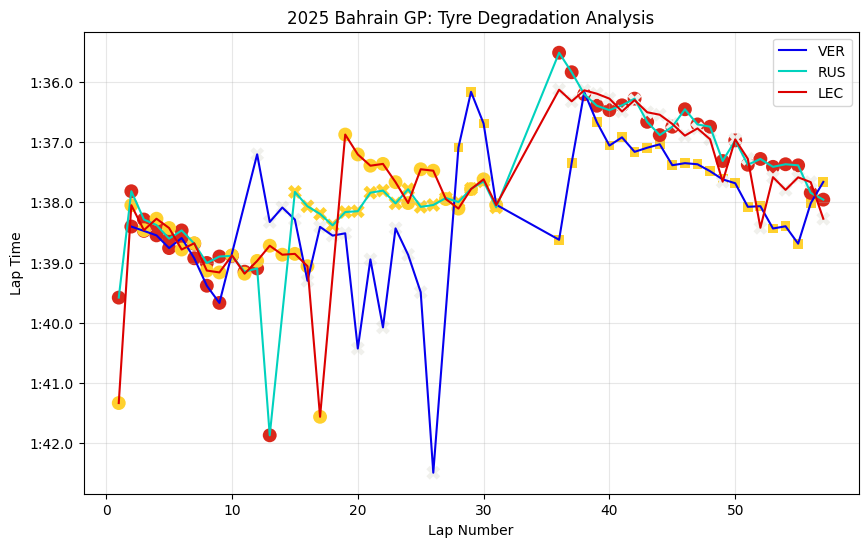

In [18]:
import seaborn as sns
import fastf1.plotting

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))

# 타이어별 색상 지정 (FastF1 내장 컬러 활용)
for driver in ['VER','RUS' , 'LEC']:
    driver_laps = laps.pick_driver(driver).pick_quicklaps().reset_index()
    
    # 전략적 인사이트: 타이어 종류별로 점 찍기
    sns.scatterplot(data=driver_laps, x="LapNumber", y="LapTime", 
                    hue="Compound", style="Compound", 
                    palette=compound_colors , s = 100, linewidth=0 , legend=False , ax=ax)
    
    # 추세선 (페이스 변화)
    sns.lineplot(data=driver_laps, x="LapNumber", y="LapTime", label=driver, 
                 color= driver_colors[driver], errorbar=None , ax= ax)

plt.title("2025 Bahrain GP: Tyre Degradation Analysis")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time")
plt.grid(True, alpha=0.3)
plt.show()

### 여기서 각 스틴트 별 평균 랩타임 감소율(기울기)를 계산하여 텍스트로 주기

- {Driver_name} 의 {Tire_compund}는 랩당 {time} 초 씩 느려진다...
    - 라는 대답을 LLM이 해야하니까..!!

------

- 할 일: 각 스틴트 별 평균 랩타임 감소율 계산하는 함수 제작
    - 인자로 (연도 , 그랑프리 지역 , Race/Qualifying 여부) 를 넣을 시
        - 전체 스틴트 별 평균 랩타임 감소율과,
        - 각각의 개별 타이어 컴파운드 별 감소율 계산하여 return 하는 함수 제작


-------

- 랩 번호(X) 가 늘어날 때 랩 타임(Y)이 얼마나 늘어나는가?
    - 1. 스틴트 나누기
    - 2. 이상치 제거 -> SC , VSC 상황에서 느려지는 랩 타임 제거
    - 3. 기울기 계산
        - 각 스틴트별로 LapNumber와 LapTime 사이의 기울기 계산
        - 기울기 > 0 : 타이어가 닳아서 느려지고 있음
        - 기울기가 0과 비슷: 타이어깎는노인 or 연료가 줄어듦

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

def calculate_tire_degradation(year, circuit, session_type, drivers=None):
    """
    특정 그랑프리의 드라이버별/스틴트별 타이어 마모도(랩타임 증가율)를 계산하는 함수
    """
    print(f"{year} {circuit} GP 데이터 로드중...")

    # 세션 로드
    session = fastf1.get_session(year, circuit , session_type)
    session.load(laps=True , telemetry=False, weather=False, messages=False)

    # 2. 드라이버 리스트 처리 (Smart Logic)
    if drivers is None:
        # 인자가 없으면, 레이스 결과 상위 10명의 코드를 자동으로 가져옴
        print("드라이버 목록이 없어 상위 10명을 자동으로 분석.")
        drivers = session.results['Abbreviation'].iloc[:10].tolist()
    
    print(f"분석 대상: {drivers}")
        
    results = []

    for driver in drivers:
        try:
            # 1. 일단 필터링 없이 '전체 랩'을 다 가져옵니다 (메타데이터용)
            all_laps = session.laps.pick_driver(driver)
            
            # 스틴트별로 반복
            for stint_id in all_laps['Stint'].unique():
                # 해당 스틴트의 전체 랩 (In-lap, Out-lap 포함)
                raw_stint = all_laps[all_laps['Stint'] == stint_id]
                
                # 타이어 종류 확인 (데이터가 없으면 패스)
                if raw_stint.empty: continue
                compound = raw_stint['Compound'].iloc[0]
                
                # 메타데이터 추출 (여기는 원본 데이터 기준)
                start_lap = raw_stint['LapNumber'].min()
                end_lap = raw_stint['LapNumber'].max()
                laps_run = len(raw_stint) # 실제 달린 랩 수
                
                # 2. 기울기 계산을 위해 '빠른 랩'만 별도로 필터링 (계산용)
                # pick_quicklaps()는 Laps 객체에서만 동작하므로 변환 필요
                clean_stint = raw_stint.pick_quicklaps().reset_index(drop=True)
                
                # 계산할 데이터가 너무 적으면(2랩 미만) 기울기 계산 스킵
                if len(clean_stint) < 2:
                    slope = 0.0 # 혹은 np.nan
                else:
                    # 선형 회귀 (LapNumber vs LapTime)
                    x = clean_stint['LapNumber']
                    y = clean_stint['LapTime'].dt.total_seconds()
                    slope, _, _, _, _ = linregress(x, y)
                
                fuel_corrected_deg = slope + 0.03 # 연료 보정 마모도 계산
                
                # 결과 저장
                results.append({
                    "Driver": driver,
                    "Stint": int(stint_id),
                    "Compound": compound,
                    "Laps_Run": laps_run,      # 실제 랩 수 (수정됨)
                    "Start_Lap": start_lap,    # 실제 시작 랩 (수정됨)
                    "End_Lap": end_lap,        # 실제 끝 랩 (수정됨)
                    "Degradation": round(slope, 4),
                    "True_Degradation":round(fuel_corrected_deg , 4)
                })
                
        except Exception as e:
            print(f"{driver} 분석 중 오류: {e}")
            continue
            
    return pd.DataFrame(results)

In [34]:
## 사용 예시

df_test_1 = calculate_tire_degradation(2025, 'Las Vegas' , 'R', drivers = ['ANT'])
df_test_1

2025 Las Vegas 데이터 로드중...
분석 대상: ['ANT']


/home/hojin/airflow-env/lib/python3.12/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


,Driver,Stint,Compound,Laps_Run,Start_Lap,End_Lap,Degradation,True_Degradation
0,ANT,1,SOFT,2,1.0,2.0,0.0000,0.0300
1,ANT,2,HARD,48,3.0,50.0,-0.0746,-0.0446


In [35]:
df_test_2 = calculate_tire_degradation(2025, 'Monza' , 'R', drivers = ['VER' , 'PIA'])
df_test_2

2025 Monza 데이터 로드중...
분석 대상: ['VER', 'PIA']


/home/hojin/airflow-env/lib/python3.12/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


,Driver,Stint,Compound,Laps_Run,Start_Lap,End_Lap,Degradation,True_Degradation
0,VER,1,MEDIUM,37,1.0,37.0,-0.0205,0.0095
1,VER,2,HARD,16,38.0,53.0,-0.0158,0.0142
2,PIA,1,MEDIUM,45,1.0,45.0,-0.0388,-0.0088
3,PIA,2,SOFT,8,46.0,53.0,-0.0865,-0.0565
